In [ ]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# CIFAR10 -> Convert to grayscale + resize 28x28 for simplicity
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.Grayscale(),
    transforms.ToTensor()
])

train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)


Using device: cpu


In [ ]:
class ConvAE(nn.Module):
    def __init__(self, code_dim=32):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),  # (1,28,28)->(16,14,14)
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # (16,14,14)->(32,7,7)
            nn.ReLU(),
        )
        self.fc_enc = nn.Linear(32*7*7, code_dim)

        self.fc_dec = nn.Linear(code_dim, 32*7*7)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x, noise_level=0.1, length_ratio=1.0):
        # ---- Encoding ----
        z = self.encoder(x)
        z = z.view(z.size(0), -1)
        z = self.fc_enc(z)

        # ---- Channel Noise ----
        noise = torch.randn_like(z) * noise_level
        z_noisy = z + noise

        # ---- Bandwidth constraint: drop last part of code ----
        effective_len = int(z_noisy.shape[1] * length_ratio)
        z_limited = torch.zeros_like(z_noisy)
        z_limited[:, :effective_len] = z_noisy[:, :effective_len]

        # ---- Decoding ----
        z_recon = self.fc_dec(z_limited)
        z_recon = z_recon.view(-1, 32, 7, 7)
        out = self.decoder(z_recon)
        return out


In [ ]:
# 3. Training Setup

model = ConvAE(code_dim=64).to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

epochs = 10
noise_levels = [0.01, 0.1, 0.3]        # different channel noise
length_levels = [1.0, 0.75, 0.5, 0.25] # bandwidth constraint

In [ ]:
# 4. Training Loop

history = []

for noise in noise_levels:
    for length_ratio in length_levels:
        print(f"\nTraining with noise={noise}, length_ratio={length_ratio}")
        for epoch in range(epochs):
            total_loss = 0
            for images, _ in train_loader:
                images = images.to(device)

                reconstructed = model(images, noise_level=noise, length_ratio=length_ratio)
                loss = loss_fn(reconstructed, images)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                total_loss += loss.item()

            avg_loss = total_loss / len(train_loader)
            print(f"Epoch [{epoch+1}/{epochs}] | Loss: {avg_loss:.5f}")
        history.append((noise, length_ratio, avg_loss))


Training with noise=0.01, length_ratio=1.0
Epoch [1/10] | Loss: 0.01141
Epoch [2/10] | Loss: 0.00484
Epoch [3/10] | Loss: 0.00417
Epoch [4/10] | Loss: 0.00404
Epoch [5/10] | Loss: 0.00395
Epoch [6/10] | Loss: 0.00389
Epoch [7/10] | Loss: 0.00386
Epoch [8/10] | Loss: 0.00383
Epoch [9/10] | Loss: 0.00381
Epoch [10/10] | Loss: 0.00379

Training with noise=0.01, length_ratio=0.75
Epoch [1/10] | Loss: 0.00545
Epoch [2/10] | Loss: 0.00500
Epoch [3/10] | Loss: 0.00494
Epoch [4/10] | Loss: 0.00490
Epoch [5/10] | Loss: 0.00487
Epoch [6/10] | Loss: 0.00485
Epoch [7/10] | Loss: 0.00484
Epoch [8/10] | Loss: 0.00482
Epoch [9/10] | Loss: 0.00481
Epoch [10/10] | Loss: 0.00480

Training with noise=0.01, length_ratio=0.5
Epoch [1/10] | Loss: 0.00733
Epoch [2/10] | Loss: 0.00678
Epoch [3/10] | Loss: 0.00671
Epoch [4/10] | Loss: 0.00668
Epoch [5/10] | Loss: 0.00665
Epoch [6/10] | Loss: 0.00664
Epoch [7/10] | Loss: 0.00663
Epoch [8/10] | Loss: 0.00661
Epoch [9/10] | Loss: 0.00661
Epoch [10/10] | Loss: 0.

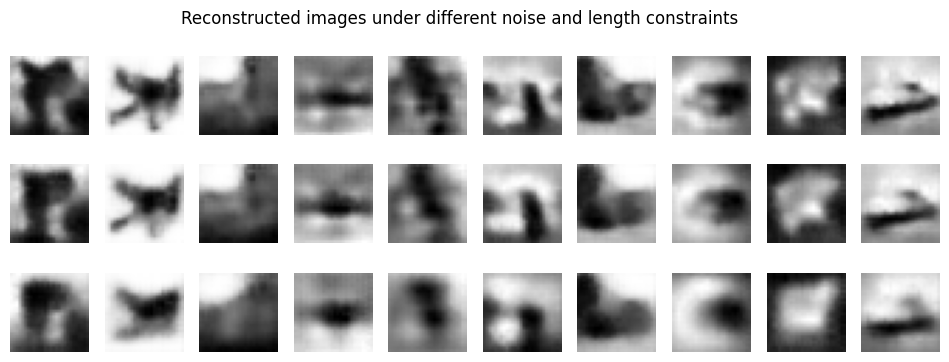

In [ ]:
# 5. Visualization


model.eval()
dataiter = iter(train_loader)
images, _ = next(dataiter)
images = images.to(device)

# Try three noise/length combinations
settings = [(0.01, 1.0), (0.1, 0.5), (0.3, 0.25)]

fig, axes = plt.subplots(len(settings), 10, figsize=(12, 4))
for row, (noise, length) in enumerate(settings):
    reconstructed = model(images, noise_level=noise, length_ratio=length)
    for i in range(10):
        axes[row, i].imshow(reconstructed[i].cpu().detach().numpy().squeeze(), cmap='gray')
        axes[row, i].axis('off')
    axes[row, 0].set_ylabel(f"N={noise}\nL={length}", fontsize=8)
plt.suptitle("Reconstructed images under different noise and length constraints")
plt.show()

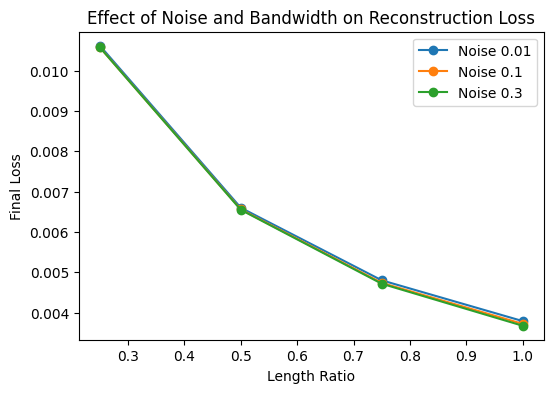

In [ ]:
# 6. Plot training summary

plt.figure(figsize=(6,4))
for noise in noise_levels:
    sub = [h[2] for h in history if h[0]==noise]
    plt.plot(length_levels, sub, marker='o', label=f"Noise {noise}")
plt.xlabel("Length Ratio")
plt.ylabel("Final Loss")
plt.title("Effect of Noise and Bandwidth on Reconstruction Loss")
plt.legend()
plt.show()